In [503]:
from gp import *
%matplotlib inline

In [488]:
class DistributedGPRegression():
    def __init__(self, X, y, n):
        self.n = n  # number of experts
        self.Experts = []
        self.X = X
        self.y = y
        for i in range(n):
            params = np.array([0, np.log(0.1 + 0.01*i), 0])
            kernel = RadialBasisFunction(params)
            Xi = self.X[i*(N//n): (i+1)*(N//n)]
            yi = self.y[i*(N//n): (i+1)*(N//n)]
            gp = GaussianProcessRegression(Xi, yi, kernel)
            self.Experts.append(gp)
        self.cholesky = True
        
    def logMl(self, params=None):
        f = 0.
        for i in range(self.n):
            f = f + self.Experts[i].logMarginalLikelihood(params)
        return f

    def gradLogMl(self, params=None):
        gradf = 0.
        for i in range(self.n):
            gradf = gradf + self.Experts[i].gradLogMarginalLikelihood(params)
        return gradf

    def train(self, disp=True):  # Optimize the sum of log-marginal likelihood
        params = np.random.randn(3,)
        res = minimize(self.logMl, params, method='BFGS',
                       jac=self.gradLogMl, options={'disp': disp})
        # update the experts
        for i in range(self.n):
            self.Experts[i].k.setParams(res.x)
        print("Train Successfull!")
    
    def mat_sqrt(self, C):
        if self.cholesky:
            return np.linalg.cholesky(C)
        return sc.linalg.sqrtm(C)
    
    def mat_square(self, L):
        if self.cholesky:
            return L @ L.T
        return L @ L
    
    def experts_preds(self, Xa):
        """returns the m, Cov of the experts
           for the Cov the cholesky decomposition will be returned
        """
        preds =[]
        for i in range(self.n):
            m_k, cov_k = self.Experts[i].predict(Xa)
            L_k = self.mat_sqrt(cov_k)
            assert np.linalg.norm((self.mat_square(L_k) - cov_k)) < 1e-7
#             print("OK ", (1+i))
            preds.append((m_k, L_k))
        return preds
    
    def fixed_point_K(self, preds, N, eps=1e-6):
        C_ = np.identity(N)
        C = C_ + 1
        n_iter = 0
        while np.linalg.norm(C - C_) > eps or n_iter > 200:
            C_ = C
            C_half = self.mat_sqrt(C_)
            Sum = np.zeros((N,N))
            for j in range(self.n):
                Sum += self.mat_sqrt(C_half @ preds[j][1] @ C_half)       
            C = (1/self.n**2) * (np.linalg.inv(C_half) @ Sum @ np.linalg.inv(C_half))
            n_iter += 1
        #end while
        return C
    
    def barycenter(self, Xa):
        N, D = Xa.shape
        preds = self.experts_preds(Xa)
        m = np.zeros(N)
        L = np.zeros((N,N))
        for j in range(self.n):
            m += preds[j][0]
            L += preds[j][1]
        m = m/self.n
        L = L/self.n
        C = self.mat_square(L)
#         C  = self.fixed_point_K(preds, N)
        return m, C

    def gbarycenter(self, Xa, ksi = 'default'):
        N, D = Xa.shape
        preds = self.experts_preds(Xa)
        if ksi is 'default':
            ksi = np.ones(self.n)/self.n
        elif ksi is 'opt':
            ksi = np.zeros((self.n,N))
            for j in range(self.n):
#                 ksi[j]= np.trace(self.mat_square(preds[j][1]))
                Xaj = Xa[j*self.n:(j+1)*self.n]
                ksi[j] = np.random.normal((j/2+ 0.5)*self.n, 1, N)
                ksi[j] /= ksi[j].sum()
                plt.figure(figsize=(18, 7))
                plt.plot(ksi[j])
                
        m = np.zeros(N)
        L = np.zeros((N,N))
        for j in range(self.n):
            m += ksi[j] * preds[j][0]
#             print(preds[j][0].shape)
            L += ksi[j] * preds[j][1]
            
        C = self.mat_square(L)
#         C  = self.fixed_point_K(preds, N)
        return m, C
    
    def predict_poe(self, Xa):
        N, D = Xa.shape
        sigma_star = np.zeros(N)
        sum_star = np.zeros(N)
        for i in range(self.n):
            m_k, cov_k = self.Experts[i].predict(Xa)
            # invert the diagonal of cov
            inv_diag = 1/np.diag(cov_k)
            sigma_star = sigma_star + inv_diag
            sum_star = sum_star + inv_diag * m_k
            
        sigma_star = 1 / sigma_star
        print("mean_sigma* = ", sigma_star.mean(), ", std_sigma* = ", sigma_star.std())
        cov_star = sigma_star * np.identity(N)
        m_star = sigma_star * sum_star
        return m_star.flatten(), cov_star

    def predict_gpoe(self, Xa, betas='default'):
        if betas is 'default':
            betas = np.ones(self.n)
        N, D = Xa.shape
        sigma_star = np.zeros(N)
        sum_star = np.zeros((N))
        for i in range(self.n):
            m_k, cov_k = self.Experts[i].predict(Xa)
            inv_diag = 1/np.diag(cov_k)
            sigma_star = sigma_star + betas[i]*inv_diag
            sum_star = sum_star + betas[i]*m_k * inv_diag

        sigma_star = 1 / sigma_star
        print("mean_sigma* = ", sigma_star.mean(), ", std_sigma* = ", sigma_star.std())
        m_star = sigma_star * sum_star
        cov_star = sigma_star * np.identity(N)
        return m_star.flatten(), cov_star

    def predict_bcm(self, Xa):
        N, D = Xa.shape
        sigma_star = np.zeros(N)
        sum_star = np.zeros(N)
        for i in range(self.n):
            m_k, cov_k = self.Experts[i].predict(Xa)
            # invert the diagonal of cov
            inv_diag = 1/np.diag(cov_k)
            sigma_star =  sigma_star + inv_diag
            sum_star = sum_star + m_k * inv_diag
            #
        sigma_prior = np.diag(self.Experts[0].k.covMatrix(Xa))
        sigma_star = sigma_star + (1-self.n)/sigma_prior
        sigma_star = 1/sigma_star
        print("mean_sigma* = ", sigma_star.mean(), ", std_sigma* = ", sigma_star.std())
        m_star = sigma_star * sum_star
        cov_star = sigma_star * np.identity(N)
        return m_star, cov_star

    def predict_rbcm(self, Xa):
        N, D = Xa.shape
        sigma_star = np.zeros(N)
        sum_star = np.zeros(N)
        sigma_prior = np.diag(self.Experts[0].k.covMatrix(Xa))
        bconst = 0.5 * np.log(sigma_prior)
        sum_betas = 0
        for i in range(self.n):
            m_k, cov_k = self.Experts[i].predict(Xa)
            # invert the diagonal of cov
            inv_diag = 1/np.diag(cov_k)
            beta = bconst - 0.5 * np.log(np.diag(cov_k))
            sum_betas = sum_betas + beta
            sigma_star = sigma_star + beta * inv_diag
            sum_star = sum_star + beta * m_k * inv_diag
            #

        sigma_star = sigma_star + (1-sum_betas) * (1/sigma_prior)
        sigma_star = 1/sigma_star
        print("mean_sigma* = ", sigma_star.mean(), ", std_sigma* = ", sigma_star.std())
        m_star = sigma_star * sum_star
        cov_star = sigma_star * np.identity(N)
        return m_star, cov_star

    def full_gp(self):
        params = np.array([0, np.log(0.1 + 0.01), 0])
        kernel = RadialBasisFunction(params)
        fgp = GaussianProcessRegression(self.X, self.y, kernel)
        opt_params = fgp.optimize(params)
        fgp.KMat(self.X, opt_params)
        return fgp


if __name__ == '__main__':

    np.random.seed(42)

    ##########################
    # You can put your tests here - marking
    # will be based on importing this code and calling
    # specific functions with custom input.
    ##########################

# Train DGP

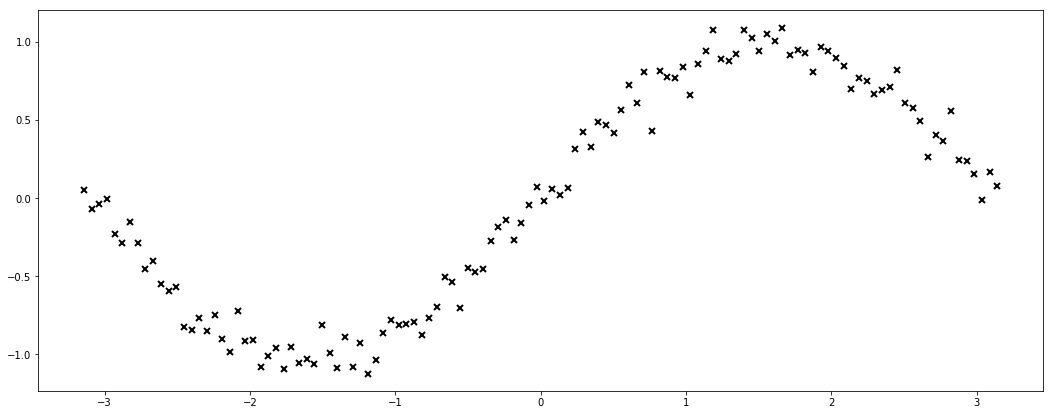

In [489]:
# lambda function, call f(x) to generate data
#f = lambda x: -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)
f = lambda x: np.sin(x)
N = 120
# N equally spaced sample locations 
X = np.linspace(-np.pi, np.pi, N)[:,None]

# y = f(X) + epsilon
y = f(X) + np.random.normal(0., 0.1, (N,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

# Setup our figure environment
plt.figure(figsize=(18, 7))

# # Plot observations
plt.plot(X, y, "kx", mew=2);

# # Annotate plot
# plt.xlabel("x"), plt.ylabel("f")
# plt.legend(labels=["sample points"]);

In [490]:
n = 5
dgp =  DistributedGPRegression(X,y,n)

In [491]:
full_gp = dgp.full_gp()

Optimization terminated successfully.
         Current function value: -97.609435
         Iterations: 16
         Function evaluations: 24
         Gradient evaluations: 24


In [492]:
# dgp.set_n(30)

In [493]:
A = np.ones(3)
B = np.ones((4,4))
# print(A, B)
C = 0.4*np.array([A,B])
a , b = C
print(a.shape)

(3,)


In [494]:
dgp.train()

Optimization terminated successfully.
         Current function value: -79.917411
         Iterations: 11
         Function evaluations: 17
         Gradient evaluations: 17
Train Successfull!


In [495]:
print(dgp.Experts[0].k.getParams())
np.exp(dgp.Experts[0].k.getParams())

[-0.29045531  0.22349097 -2.36967524]


array([0.74792295, 1.25043435, 0.09351109])

In [496]:
# mo, Co = dgp.Experts[1].predict(Xtest)

In [497]:
# np.linalg.cond(dgp.Experts[0].K)

In [498]:
# New test points to sample function from
Xtest = np.linspace(-5, 5, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = dgp.Experts[2].predict(Xtest)
# Full GP
# fullmean, fullCov = full_gp.predict(Xtest)

(-2, 2)

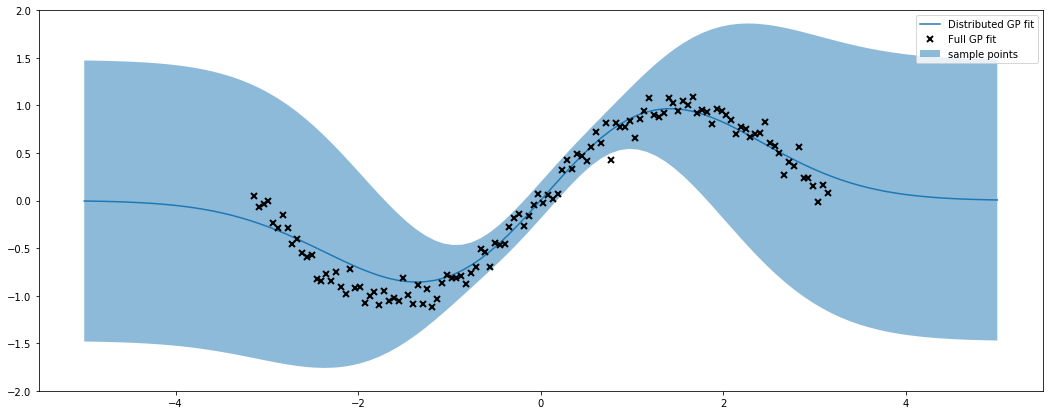

In [499]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, 0, 0, training_points=(X,y), full=False)
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)

# Barycenter 

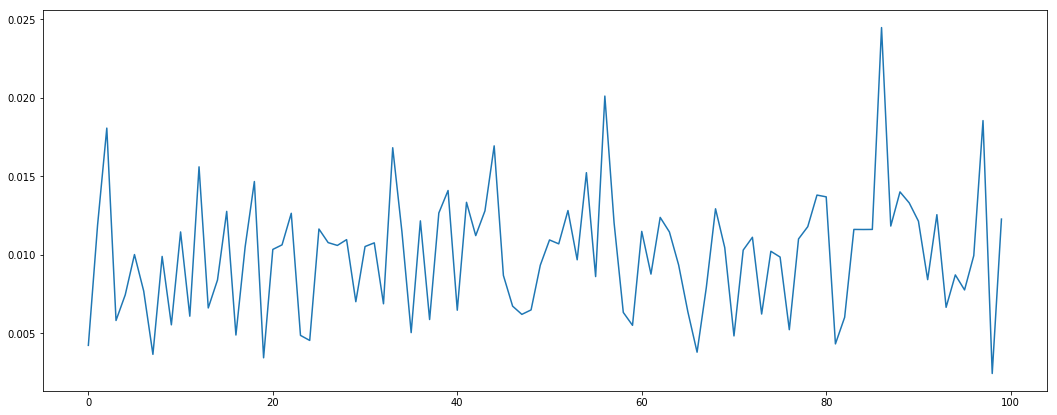

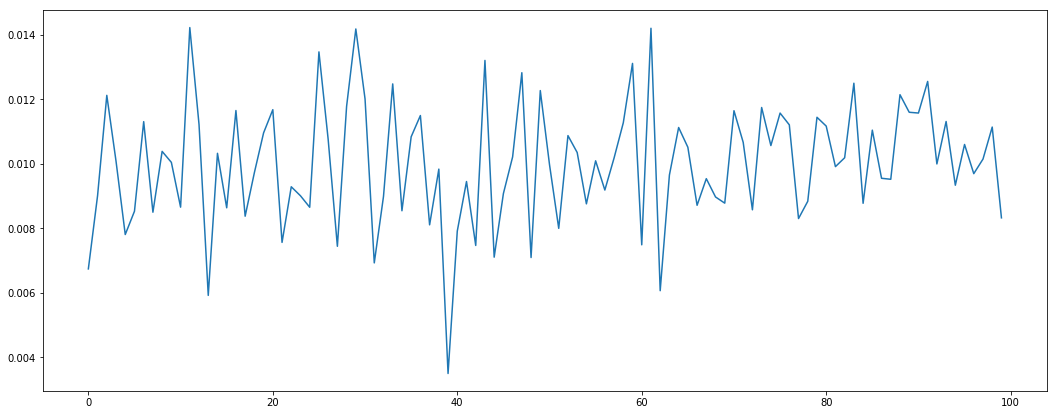

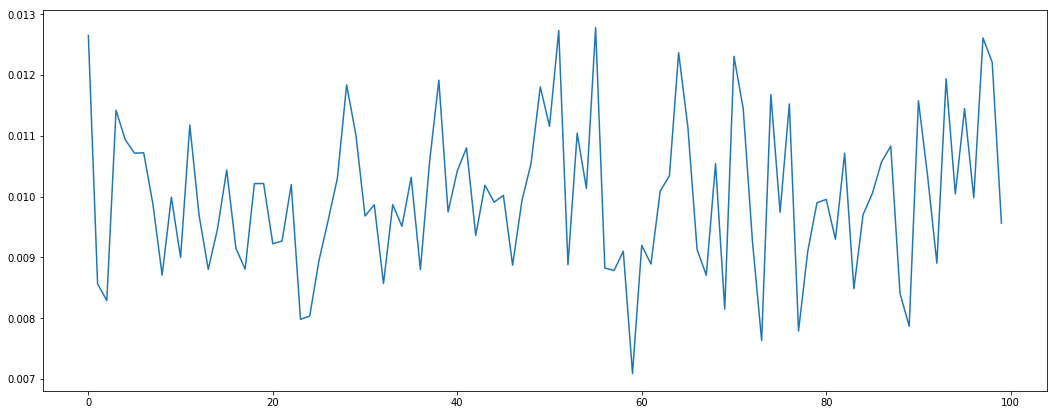

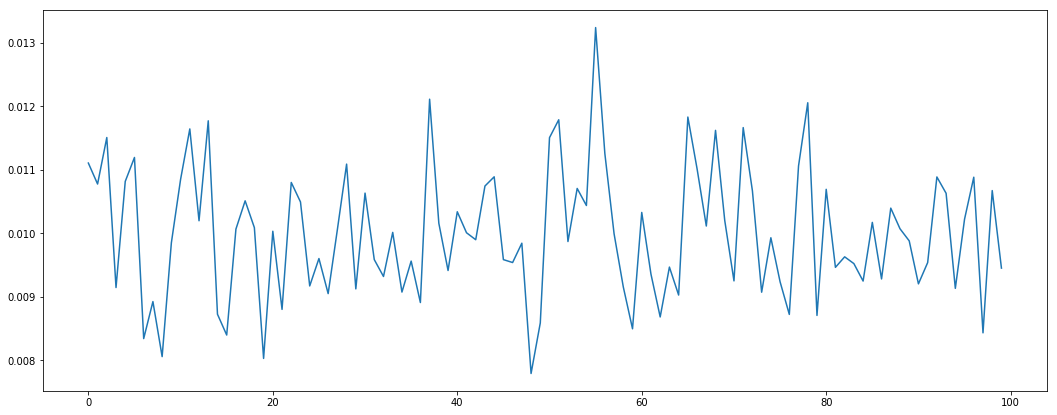

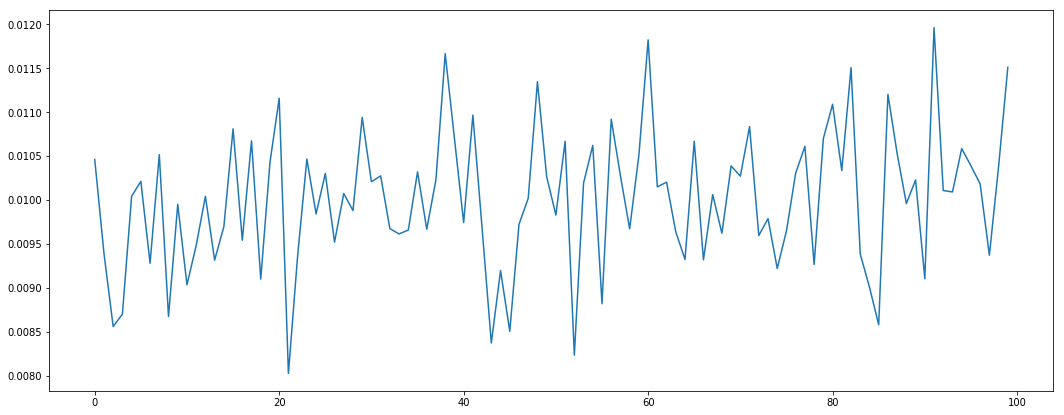

In [500]:
# New test points to sample function from
N = 100
Xtest = np.linspace(-5, 5, N)[:, None]
# ksi = np.random.randn(dgp.n)
# ksi /= ksi.sum()
ksi = np.zeros((dgp.n, N))
for j in range(dgp.n):
    ksi[j,j*(N//dgp.n):(j+1)*(N//dgp.n)] = 1
# Get mean and covariance of optimised GP
default_mean, default_Cov = dgp.gbarycenter(Xtest)
opt_mean, opt_Cov = dgp.gbarycenter(Xtest,ksi='opt')
mean, Cov = dgp.gbarycenter(Xtest,ksi)
# Full GP
fullmean, fullCov = full_gp.predict(Xtest)
# dgp.barycenter

(-2, 2)

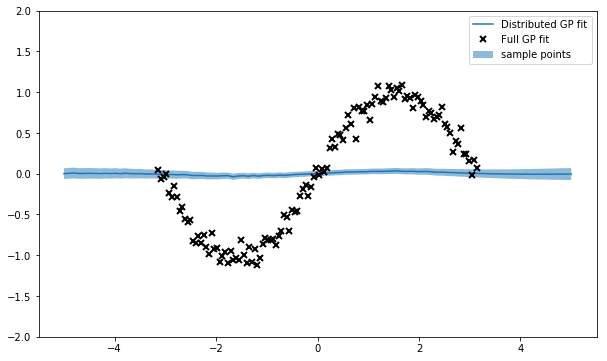

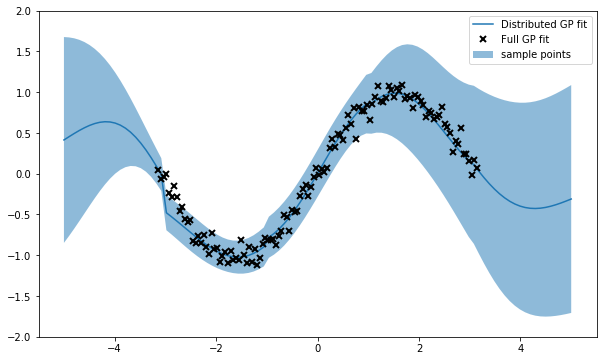

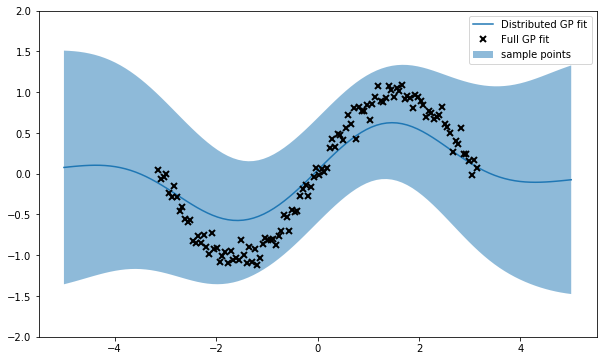

In [501]:
plt.figure(figsize=(10,6))
plot_dgp(Xtest, opt_mean.reshape(-1,1), opt_Cov, 0, 0, training_points=(X,y), full=False)
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
plt.figure(figsize=(10,6))
plot_dgp(Xtest, mean.reshape(-1,1), Cov, 0, 0, training_points=(X,y), full=False)
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
plt.figure(figsize=(10,6))
plot_dgp(Xtest, default_mean.reshape(-1,1), default_Cov, 0, 0, training_points=(X,y), full=False)
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)

(-2, 2)

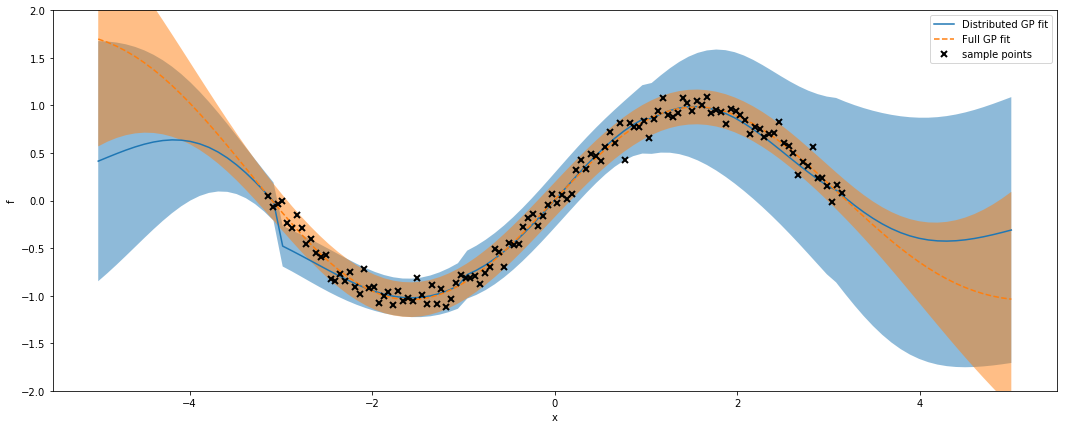

In [502]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, fullmean.reshape(-1,1), fullCov, training_points=(X,y))
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
# xv = [X.min() + (X.max()-X.min())*j/(n-1) for j in range(dgp.n)]

# plt.vlines(xv, -2, 2);

# Product of Experts

In [214]:
# New test points to sample function from
Xtest = np.linspace(-5, 5, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = dgp.predict_gpoe(Xtest)
# Full GP
fullmean, fullCov = full_gp.predict(Xtest)

mean_sigma* =  0.03457489299114193 , std_sigma* =  0.04759752927079977


(-2, 2)

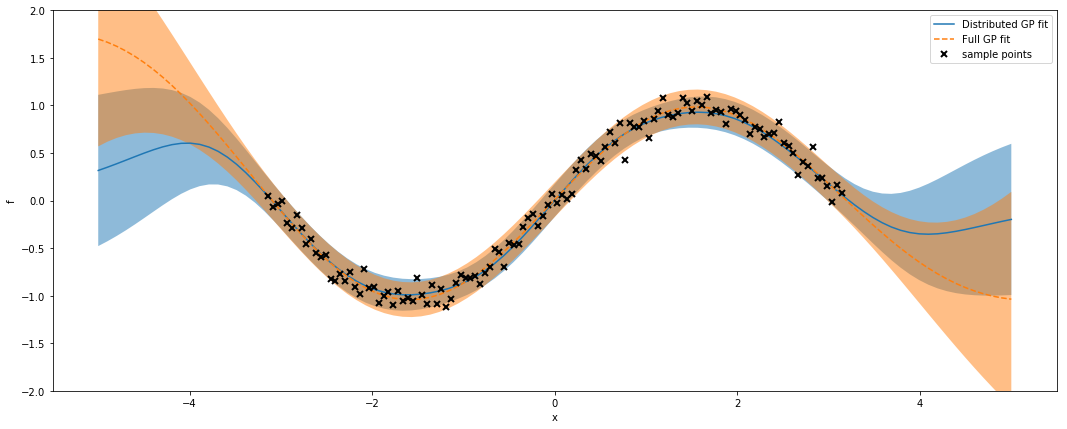

In [151]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, fullmean.reshape(-1,1), fullCov, training_points=(X,y))
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
# xv = [X.min() + (X.max()-X.min())*j/(n-1) for j in range(dgp.n)]

# plt.vlines(xv, -2, 2);

# Generalized Product of Experts

In [114]:
## Define Weights 
betas = [1/dgp.n]*dgp.n
# New test points to sample function from
Xtest = np.linspace(-5, 5, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = dgp.predict_gpoe(Xtest, betas)
# Full GP
fullmean, fullCov = full_gp.predict(Xtest)

mean_sigma* =  0.10372467897342577 , std_sigma* =  0.14279258781239934


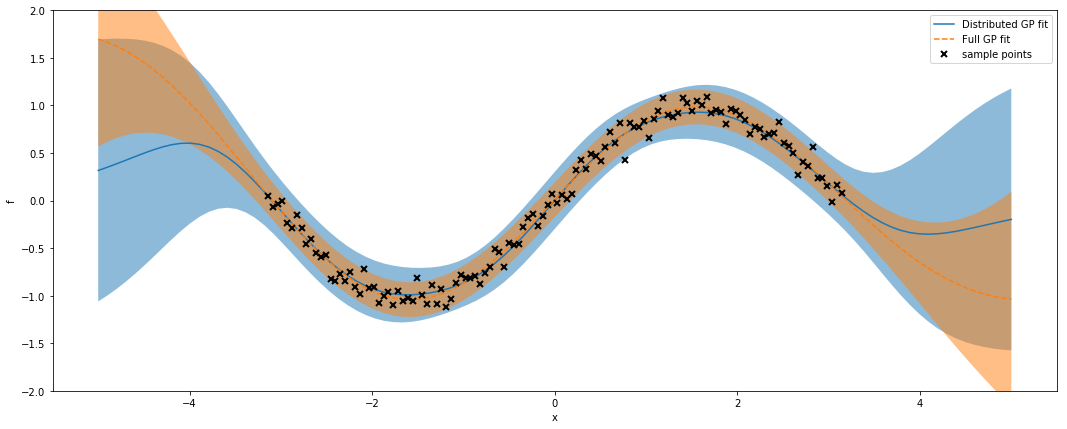

In [110]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, fullmean.reshape(-1,1), fullCov, training_points=(X,y))
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
xv = [X.min() + (X.max()-X.min())*j/(n-1) for j in range(dgp.n)]

# plt.vlines(xv, -2, 2);

# BCM

In [90]:
# New test points to sample function from
Xtest = np.linspace(-5, 5, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = dgp.predict_bcm(Xtest)
# Full GP
fullmean, fullCov = full_gp.predict(Xtest)

mean_sigma* =  0.07056153795190268 , std_sigma* =  0.12822619858223638


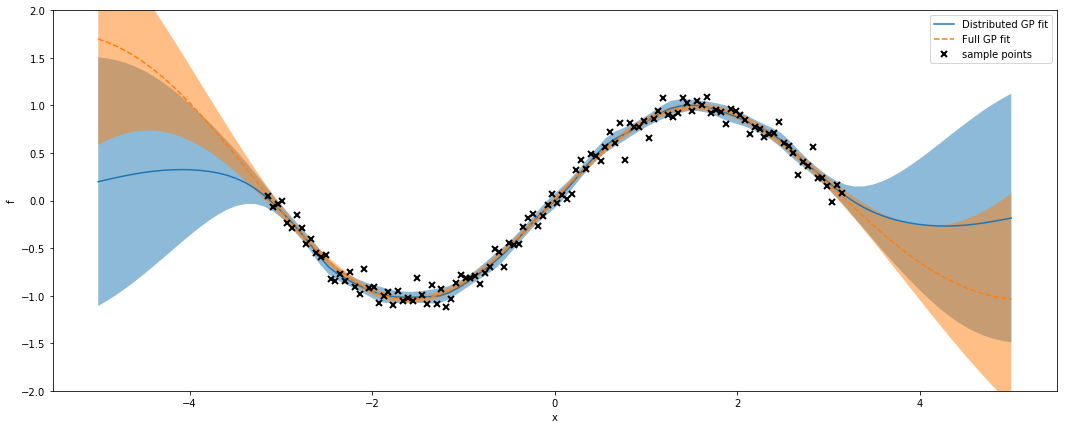

In [91]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, fullmean.reshape(-1,1), fullCov, training_points=(X,y))
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
xv = [X.min() + (X.max()-X.min())*j/(n-1) for j in range(dgp.n)]

# plt.vlines(xv, -2, 2);

# rBCM

In [92]:
# New test points to sample function from
Xtest = np.linspace(-5, 5, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = dgp.predict_rbcm(Xtest)
# Full GP
fullmean, fullCov = full_gp.predict(Xtest)

mean_sigma* =  0.10433637824306789 , std_sigma* =  0.19405111899589234


(-2, 2)

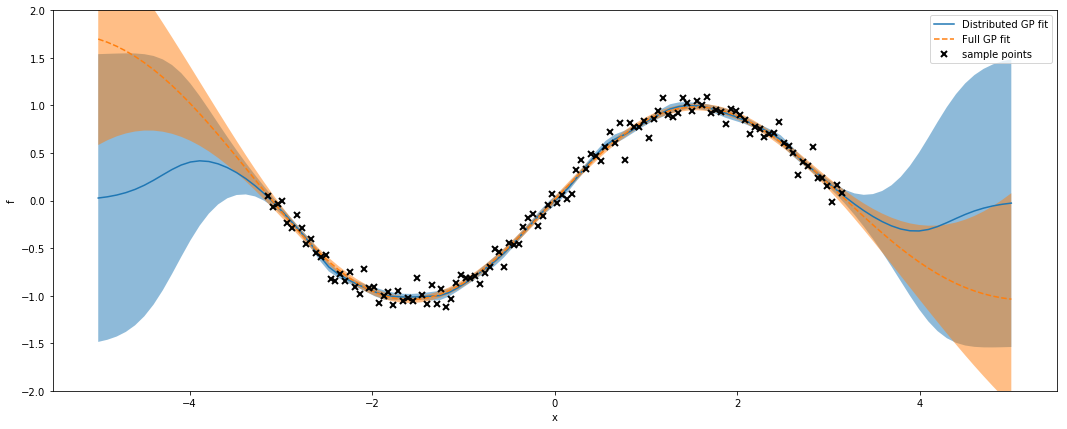

In [93]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, fullmean.reshape(-1,1), fullCov, training_points=(X,y))
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
# xv = [X.min() + (X.max()-X.min())*j/(n-1) for j in range(dgp.n)]

# plt.vlines(xv, -2, 2);

# 2D - data (...)

In [63]:

# Lambda function, f, the unknown function we are trying to predict
f = lambda x: np.sin(x[:,0]) * np.sin(x[:,1])

# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))

# Number of samples [YOU CAN PLAY AROUND WITH THE NUMBER OF RANDOM SAMPLES TO SEE HOW THE FIT IS AFFECTED]
num_measurements = 120

# Random sample locations (2-D)
X2 = np.random.uniform(-np.pi, np.pi, (num_measurements, 2))
y2 = f(X2)

In [64]:
n = 3
dgp =  DistributedGPRegression(X2,y2,n)

In [65]:
dgp.train()

         Current function value: -158.890494
         Iterations: 28
         Function evaluations: 69
         Gradient evaluations: 59
Train Successfull!


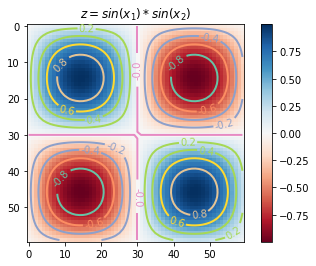

In [66]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x,y):
  X = np.array([x,y])[None,:]
  return f(X)[0]
 
x = arange(-3.0,3.0,0.1)
y = arange(-3.0,3.0,0.1)
X,Y = meshgrid(x, y) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z,cmap=cm.RdBu) # drawing the function
# adding the Contour lines with labels
cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
# latex fashion title
title('$z=sin(x_1)*sin(x_2)$')
show()

In [67]:
X_test = np.array([X.flatten(),Y.flatten()]).T
# dgp.predict(X_test)

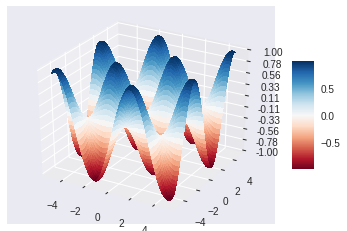

In [0]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()